# Методика управления валютным портфелем через абсолютные валютные курсы

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle

import lib_portf_optim as po
import lib_ga as ga

# Загрузка котировок

In [2]:
data = pd.read_csv('../input/abscur/close_abs.csv',index_col=0)
d_data = data.pct_change().fillna(0)
data

,AUD,CAD,HKD,JPY,SEK,USD,CHF,EUR,CNY,CZK,...,PKR,PLN,QAR,RON,SAR,THB,TRY,TWD,UAH,VND
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-27,12.707662,12.628152,2.134768,0.147652,1.832696,16.570447,16.417864,17.473901,2.408537,0.647274,...,0.159669,4.052841,4.551821,3.879304,4.419022,0.475588,4.604194,0.540564,0.617678,0.000728
2017-02-28,12.735078,12.582107,2.137765,0.147133,1.831139,16.590732,16.433774,17.556971,2.416267,0.650186,...,0.158460,4.072045,4.558770,3.893076,4.429747,0.476198,4.599721,0.541261,0.613563,0.000729
2017-03-01,12.688710,12.474608,2.139114,0.146810,1.835955,16.606034,16.491160,17.539620,2.419103,0.649514,...,0.158606,4.076471,4.563100,3.884907,4.433714,0.475409,4.559342,0.541972,0.610965,0.000742
2017-03-02,12.743684,12.463166,2.143677,0.145797,1.837701,16.641409,16.469319,17.527312,2.419234,0.648854,...,0.159020,4.097466,4.572695,3.878483,4.443634,0.475333,4.558665,0.541061,0.619561,0.000740
2017-03-03,12.627507,12.455957,2.148750,0.145841,1.837562,16.679247,16.458753,17.520745,2.422956,0.648545,...,0.161214,4.078295,4.583092,3.878444,4.453619,0.475924,4.475536,0.541798,0.622755,0.000730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-21,13.437193,14.688083,2.402213,0.162983,1.993264,18.734885,20.345770,21.205819,2.963032,0.872542,...,0.106995,4.685385,5.146946,4.299852,4.993839,0.583060,1.376747,0.672224,0.667358,0.000821
2022-02-22,13.472992,14.700175,2.403827,0.163613,1.986585,18.747253,20.473565,21.205431,2.962015,0.869848,...,0.107151,4.666165,5.150344,4.292052,5.002323,0.581166,1.370864,0.674061,0.663747,0.000822
2022-02-23,13.545096,14.681093,2.402122,0.162805,2.010078,18.743661,20.333574,21.230372,2.964893,0.865791,...,0.107107,4.671399,5.149357,4.297822,4.996577,0.578223,1.361959,0.673327,0.653822,0.000822


# Модуль прогноза на шаг вперед

In [3]:
def get_pred(learn_array):
    '''
    функция генерации распределения портфеля на следующий период
    
    learn_array - массив относительных изменений курсов за предыдущий период
    
    возвращает массив долей портфеля на будущий период
    расчитывает по максимизации коэффициента Шарпа
    '''
    doh = np.mean(learn_array,axis=0)
    cov = np.cov(learn_array,rowvar=False)
    return po.portfSharpOptim(doh,cov)

# get_pred(d_data.iloc[-50:,:]) # на основе 50 предыдущих значений

# Создание/загрузка модели генетической оптимизации

In [4]:
# функция качества
def getQualityMethod(learn_len,rebalace_len):
    '''
    подсчет качества для модели в случайной точке
    
    learn_len - размер обучающей выборки перед ребалансировкой
    rebalace_len - период ребалансировки портфеля
    '''
    
    # получение выборок обучения и следующей за ней рабочей (равной периоду ребалансировки)
    x = np.random.randint(1,len(d_data)-learn_len-rebalace_len)
    learn_vib = d_data.iloc[x:x+learn_len,:].values
    work_vib = d_data.iloc[x+learn_len:x+learn_len+rebalace_len,:].values
    
    # расчет долей портфеля на выборке обучения
    weights = get_pred(learn_vib)
    
    # расчет качества на рабочей выборке по прогнозным долям
    doh = np.mean(work_vib,axis=0)
    cov = np.cov(work_vib,rowvar=False)
    kach = po.koefSharp(weights,doh,cov)
    
    # расчет качества на рабочей выборке по равным долям 
    weights_0 = np.ones_like(weights) / len(weights)
    kach_0 = po.koefSharp(weights_0,doh,cov)
    
    return kach - kach_0 # смотрим как отрываемся от равномерной модели
    
# getQualityMethod(50,10)

# создание модели генетики
modelGA = ga.ListGenetic( 
    pop_size = 1000,
    learn_len = range(50,500),
    rebalace_len = range(30,300),
    quality_method=getQualityMethod
)

# загрузка предыдущей модели генетики
fn = '../input/abscur-meth-contr-portf-curs/model_ga.pkl'
if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

# Параметры лучшей

# Распределение по данным лучшей модели

# Прогон на лучших параметрах

# Цикл генетической оптимизации гиперпараметров

In [5]:
modelGA.fit(10000,echo_time=60,stop_time_sec=8*60*60)
with open("model_ga.pkl",'wb') as fp:
    pickle.dump(modelGA,fp)

110232 {'quality': -0.09481112715441858, 'learn_len': 258, 'rebalace_len': 190}
110465 {'quality': -0.43221643262938425, 'learn_len': 259, 'rebalace_len': 281}
110698 {'quality': -0.12777548099800073, 'learn_len': 239, 'rebalace_len': 248}
110932 {'quality': -0.3055018788554888, 'learn_len': 261, 'rebalace_len': 256}
111166 {'quality': -0.03238404258491573, 'learn_len': 288, 'rebalace_len': 244}
111399 {'quality': -0.47075616455913516, 'learn_len': 258, 'rebalace_len': 233}
111633 {'quality': -0.15334190860497315, 'learn_len': 292, 'rebalace_len': 236}
111867 {'quality': -0.1711836354776506, 'learn_len': 273, 'rebalace_len': 241}
112101 {'quality': -0.10801845894127426, 'learn_len': 262, 'rebalace_len': 215}
112337 {'quality': -0.1734111433047953, 'learn_len': 259, 'rebalace_len': 243}
112572 {'quality': -0.19362148117876293, 'learn_len': 256, 'rebalace_len': 230}
112807 {'quality': -0.4340172387995761, 'learn_len': 272, 'rebalace_len': 275}
113042 {'quality': 0.19712455231686643, 'lea

# Отчет по оптимизации гиперпараметров

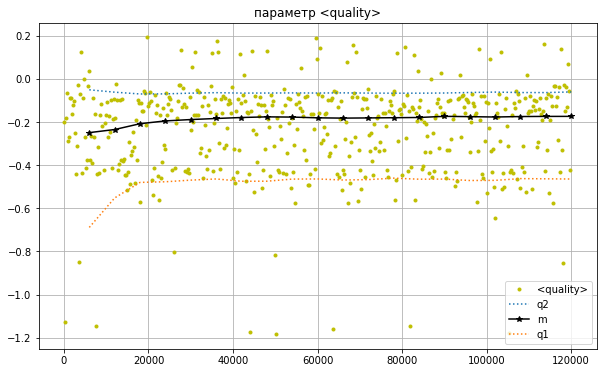

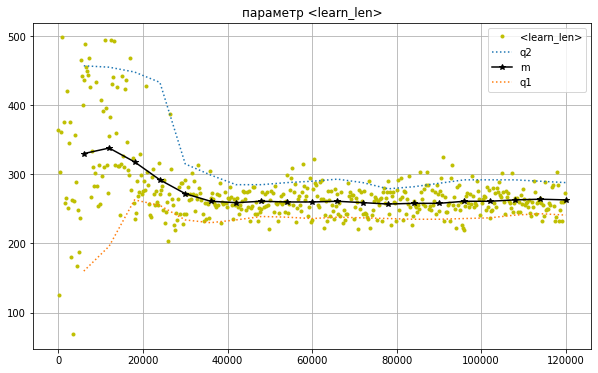

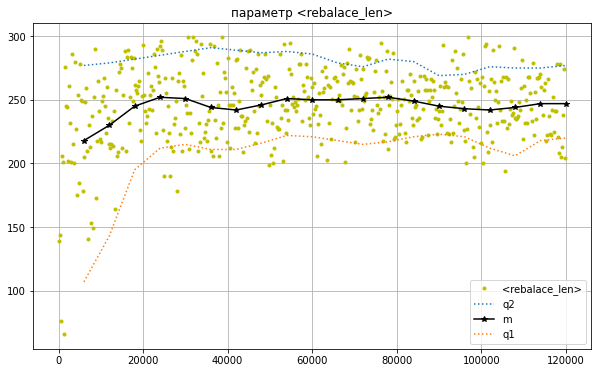

In [6]:
modelGA.plot_hist_new(('quality','learn_len','rebalace_len'))